In [1]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile, assemble
# try different simulators 
# https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html
backend = Aer.get_backend("aer_simulator")
NUM_SHOTS = 1000

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


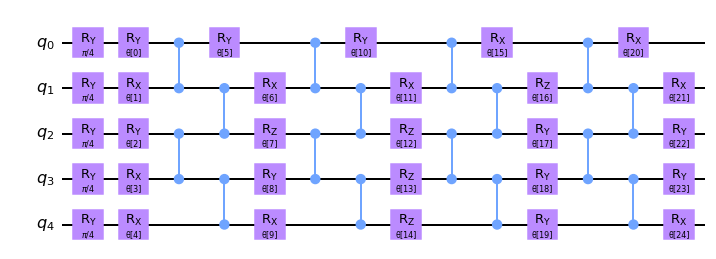

In [2]:
from qiskit.circuit.library import PauliTwoDesign
from qiskit.opflow import Z,I,StateFn

# number of qubits
N = 5
# depth 
L = 4

qc = PauliTwoDesign(num_qubits=N, reps=L)
tqc = transpile(qc, backend)
tqc.draw('mpl')

In [7]:
initial_point = np.random.random(qc.num_parameters)

# H = ZZZZ...Z
H = Z.tensorpower(N)

def gradient(params,i):
    x1 = np.copy(params)
    x1[i] += np.pi/2
    x2 = np.copy(params)
    x2[i] -= np.pi/2
    psi1 = StateFn(qc.assign_parameters(x1))
    psi2 = StateFn(qc.assign_parameters(x2))
    # ~ is the dagger operator, @ is matrix-vector product
    r1 = (~psi1 @ H @ psi1).eval() # <psi1|H|psi1>
    r2 = (~psi2 @ H @ psi2).eval() # <psi2|H|psi2>
    return np.real(r1-r2)/2
   
gradient(initial_point,1)

0.0062852232409780625

In [11]:
def randomgradient(nqubits,nlayers,i):
    q = PauliTwoDesign(num_qubits=nqubits, reps=nlayers)
    params = (2*np.pi)*np.random.random(q.num_parameters)
    cost = Z.tensorpower(nqubits) # example cost.. 
    x1 = np.copy(params)
    x1[i] += np.pi/2
    x2 = np.copy(params)
    x2[i] -= np.pi/2
    psi1 = StateFn(q.assign_parameters(x1))
    psi2 = StateFn(q.assign_parameters(x2))
    # ~ is the dagger operator, @ is matrix-vector product
    r1 = (~psi1 @ cost @ psi1).eval() 
    r2 = (~psi2 @ cost @ psi2).eval() 
    return np.real(r1-r2)/2
    
randomgradient(5,15,1)

0.007542416190517071

In [12]:
stat = np.array([randomgradient(5,10,1) for i in range(100)])
np.mean(np.abs(stat))

0.07074299215750353

In [13]:
randomgradient(10,10,1)

0.0010224680661673202

In [14]:
randomgradient(16,10,1)

0.005525416046447833

In [15]:
randomgradient(16,16,1)

0.0018893142572707952

# Scaling analysis

In [9]:
def gradscaling(nqubits,nlayers,i,reps):
    g = np.array([randomgradient(nqubits,nlayers,i) for k in range(reps)])
    return [nqubits, np.mean(g),np.var(g)]


res = [gradscaling(n,n,1,200) for n in range(2,9)]
    

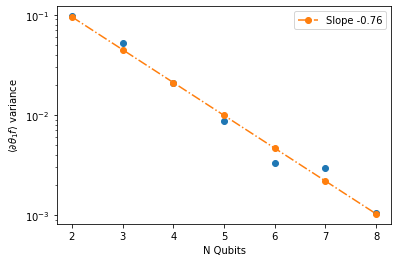

In [10]:
import matplotlib.pyplot as plt

qubits = np.array([v[0] for v in res])
means = np.array([v[2] for v in res])
variances = np.array([v[2] for v in res])

# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances), 1)

# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances, "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1} f\rangle$ variance")
plt.legend()
plt.show()

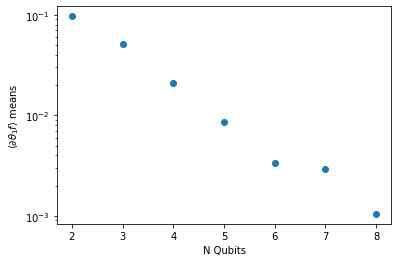

In [11]:
plt.semilogy(qubits, means, "o")
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1} f\rangle$ means")
plt.show()

# Local cost functions

In [14]:
Z.tensor(I.tensorpower(5))

PauliOp(Pauli('ZIIIII'), coeff=1.0)

In [12]:
def randomgradientlocal(nqubits,nlayers,i):
    q = PauliTwoDesign(num_qubits=nqubits, reps=nlayers)
    params = (2*np.pi)*np.random.random(q.num_parameters)
    cost = Z.tensor(I.tensorpower(nqubits-1)) # example local cost.. 
    x1 = np.copy(params)
    x1[i] += np.pi/2
    x2 = np.copy(params)
    x2[i] -= np.pi/2
    psi1 = StateFn(q.assign_parameters(x1))
    psi2 = StateFn(q.assign_parameters(x2))
    # ~ is the dagger operator, @ is matrix-vector product
    r1 = (~psi1 @ cost @ psi1).eval() 
    r2 = (~psi2 @ cost @ psi2).eval() 
    return np.real(r1-r2)/2

def gradscalinglocal(nqubits,nlayers,i,reps):
    g = np.array([randomgradientlocal(nqubits,nlayers,i) for k in range(reps)])
    return [nqubits, np.mean(g),np.var(g)]


resl = [gradscalinglocal(n,n,1,200) for n in range(2,9)]

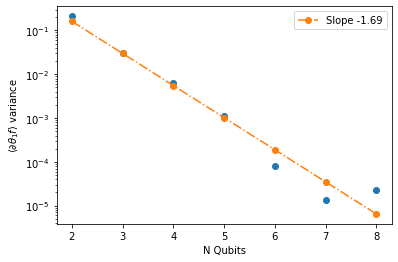

In [13]:
import matplotlib.pyplot as plt

qubits = np.array([v[0] for v in resl])
means = np.array([v[2] for v in resl])
variances = np.array([v[2] for v in resl])

# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances), 1)

# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances, "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1} f\rangle$ variance")
plt.legend()
plt.show()

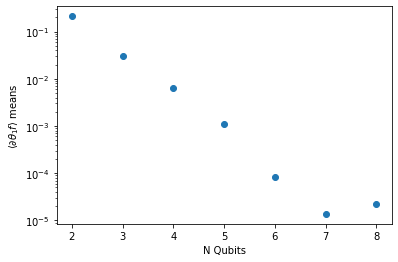

In [14]:
plt.semilogy(qubits, means, "o")
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1} f\rangle$ means")
plt.show()

# Avoiding barren plateau

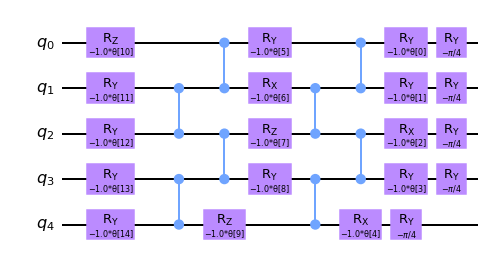

In [15]:
qc1=PauliTwoDesign(num_qubits=N, reps=int(L/2))
transpile(qc1.inverse(),backend).draw('mpl')

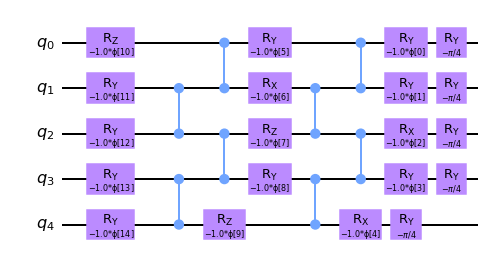

In [16]:
from qiskit.circuit import ParameterVector
qc2 = qc1.inverse().assign_parameters(ParameterVector('ϕ',qc1.num_parameters))
transpile(qc2,backend).draw('mpl')

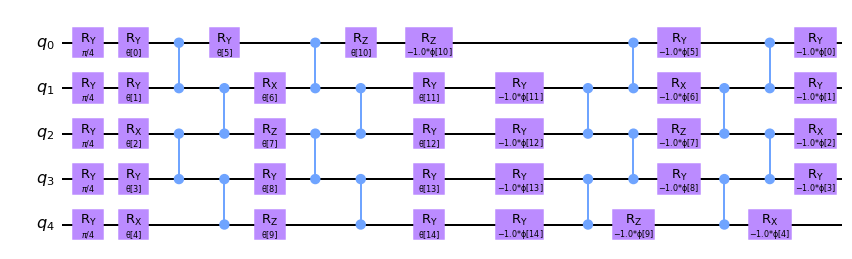

In [17]:
qc = qc1.compose(qc2)
for i in range(5):
    qc.ry(np.pi/4,i)
transpile(qc,backend).draw('mpl')

In [18]:
qc = qc1.compose(qc2)
par = (2*np.pi)*np.random.random(qc1.num_parameters)
StateFn(qc.assign_parameters(np.concatenate([par,par]))).eval()

VectorStateFn(Statevector([1.-1.673e-15j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j,
             0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j,
             0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j,
             0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j,
             0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j,
             0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j,
             0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j,
             0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j, 0.+0.000e+00j],
            dims=(2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)

In [19]:
par = (2*np.pi)*np.random.random(qc.num_parameters)
StateFn(qc.assign_parameters(par)).eval()

VectorStateFn(Statevector([-0.04665876-0.04999365j, -0.02619509+0.00101873j,
              0.00664953+0.05612196j, -0.06705035-0.11012521j,
             -0.02927641-0.01357773j,  0.0569839 +0.0770444j ,
              0.07750378+0.03564352j,  0.05538581+0.30273345j,
             -0.09440096-0.08235071j, -0.11319711+0.01584984j,
             -0.00886498+0.12798739j, -0.36532052-0.2575465j ,
              0.0497531 +0.05719492j,  0.02240195+0.0116163j ,
             -0.00233245-0.04742287j,  0.02911568+0.15260974j,
              0.07270987-0.03155397j,  0.01466039-0.08096061j,
             -0.07693869-0.04368147j,  0.24189595-0.18690157j,
             -0.03528105+0.05317224j,  0.05305706-0.03336474j,
              0.04830301-0.06689996j,  0.1534419 -0.02594004j,
             -0.07599584+0.10138663j, -0.00595629+0.14428487j,
              0.12444162+0.02722225j, -0.37720456+0.44004513j,
              0.09181022-0.09440618j, -0.05886683+0.00279063j,
             -0.10762361+0.06590653j, -0.

In [20]:
def randomgradientnoplateau(nqubits,nlayers,i):
    q1 = PauliTwoDesign(num_qubits=nqubits, reps=int(nlayers/2))
    q2 = q1.inverse().assign_parameters(ParameterVector('θdag',q1.num_parameters))
    q = q1.compose(q2)
    for i in range(nqubits):
        q.ry(np.pi/4,i)
    par = (2*np.pi)*np.random.random(q1.num_parameters)
    # same parameters for the two blocks, note that in the second block the parameters have a minus sign
    params = np.concatenate([par,par]) 
    cost = Z.tensor(I.tensorpower(nqubits-1)) # example local cost.. 
    x1 = np.copy(params)
    x1[i] += np.pi/2
    x2 = np.copy(params)
    x2[i] -= np.pi/2
    psi1 = StateFn(q.assign_parameters(x1))
    psi2 = StateFn(q.assign_parameters(x2))
    # ~ is the dagger operator, @ is matrix-vector product
    r1 = (~psi1 @ cost @ psi1).eval() 
    r2 = (~psi2 @ cost @ psi2).eval() 
    return np.real(r1-r2)/2
    
randomgradientnoplateau(4,4,8)

-0.707106781186545

In [21]:
def gradscalingnoplat(nqubits,nlayers,i,reps):
    g = np.array([randomgradientnoplateau(nqubits,nlayers,i) for k in range(reps)])
    return [nqubits, np.mean(g),np.var(g)]


res2 = [gradscalingnoplat(n,n,2*n,200) for n in range(2,9)]

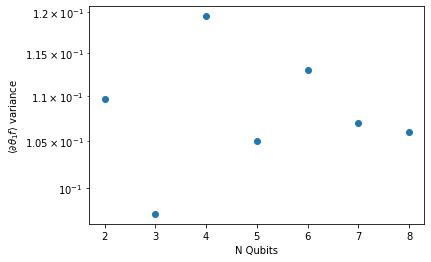

In [23]:
import matplotlib.pyplot as plt

qubits = np.array([v[0] for v in res2])
means = np.array([v[2] for v in res2])
variances = np.array([v[2] for v in res2])

# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances, "o")
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1} f\rangle$ variance")
plt.show()